In [1]:
import av as av
import pims
import trackpy as tp
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import fft
from sklearn.decomposition import PCA ## need this for principle component analysis below
from matplotlib.mlab import psd
from scipy.optimize import minimize, curve_fit
from scipy.stats import chi2


#make a pipeline so that when pims opens a file, it converts each frame to one color
@pims.pipeline
def gray(image):
    return image[:, :, 1]  # Take just the green channel (they are all the same for our camera)


def processmovie(filename, framerate):
    #open a avi file with pims and converts to one color
    spheres = gray(pims.open(filename))

    #process every frame in the tiff image stack to find the locations of bright spots
    #minmass defines the minimum brightness and processes means no parallelization since that breaks it
    #invert=true looks for dark spots instead of light spots
    f = tp.batch(spheres[:], 15, invert=False, minmass=1000, processes=1)
    #to check the mass brightness make this figure
    fig, ax = plt.subplots()
    ax.hist(f['mass'], bins=100)

    return [spheres, f]
    


In [2]:
from scipy.signal.windows import blackman

def PSDmaker(spheres, f):
    
    #look at the location in each frame and labels them. It looks for maximum 5 pixel movement between frames
    #if it vanishes for one frame, memory prevents it from thinking the sphere is gone (up to 3 frames)
    t = tp.link(f, 40, memory=20)
    #suppress output so that it runs faster
    tp.quiet()

    tracks = plt.figure(0)
    #plot the trajectory of the sphere over the video
    tp.plot_traj(t)

    ypx = t.loc[:,'y']
    xpx = t.loc[:,'x']
    spherenumber = t.loc[:,'particle']
    ypos = ypx * 0.83 * 10**(-6) #convert pixel to meter (10 um sphere takes 12-13 pixels)
    xpos = xpx * 0.83 * 10**(-6) #convert pixel to meter

    totalspheres = 1 #max(t.loc[:,'particle']) # broken, doesn't alwasy give the max
    xposlist = [[] for i in range(totalspheres)]
    yposlist = [[] for i in range(totalspheres)]


    #sort the dataframe to get the x,y position for each sphere
    for i in range(0, t.shape[0]):
        xposlist[spherenumber[i]].append(xpos[i])
        yposlist[spherenumber[i]].append(ypos[i])


    #make an array of the time for each frame in the video
    timeinc = 1/framerate 
    numframes = len(spheres) #gets number of frames in the video
    time = np.arange(0, numframes*timeinc, timeinc)
    freq = fft.rfftfreq(numframes, timeinc)
    w = blackman(numframes)


    xASDlist = [[] for i in range(totalspheres)]
    yASDlist = [[] for i in range(totalspheres)]

    for i in range(0,len(xposlist)):
        
        xcentered = xposlist[i] - np.mean(xposlist[i])
        xPSD = 2 * timeinc / numframes * np.abs(fft.rfft(xcentered*w))**2
        xASD = np.sqrt(xPSD)
        xASDlist[i] = xASD
        

        ycentered = yposlist[i] - np.mean(yposlist[i])
        yPSD = 2 * timeinc / numframes * np.abs(fft.rfft(ycentered*w))**2
        yASD = np.sqrt(yPSD)
        yASDlist[i] = yASD
        


    Legend = []
    xpsdplots = plt.figure(1)
    for i in range(0,len(xASDlist)):
        if len(freq) == len(xASDlist[i]):
            plt.loglog(freq, xASDlist[i])
            Legend.append('Sphere ' + str(i+1))
        else:
            print('Sphere ' +str(i+1) + ' has dropped frames')
        
    plt.ylim([1e-10, 1e-5])
    #plt.xlim([1,100])
    plt.xlabel('Frequency [Hz]')
    plt.ylabel(r'ASD [$m/ \sqrt{Hz}$]')
    plt.legend(Legend)
    plt.title('X motion ASD')
    plt.grid()
    
    
    Legend = []
    ypsdplots = plt.figure(2)
    for i in range(0,len(yASDlist)):
        if len(freq) == len(yASDlist[i]):
            plt.loglog(freq, yASDlist[i])
            Legend.append('Sphere ' + str(i+1))
        else:
            print('Sphere ' +str(i+1) + ' has dropped frames')
        
    plt.ylim([1e-10, 1e-5])
    #plt.xlim([1,100])
    plt.xlabel('Frequency [Hz]')
    plt.ylabel(r'ASD [$m/ \sqrt{Hz}$]')
    plt.legend(Legend)
    plt.title('Y motion ASD')
    plt.grid()
    
#     sphere2 = plt.figure(2)
#     plt.loglog(freq, x1ASD)
#     plt.loglog(freq, y1ASD)
#     plt.ylim([1e-9, 1e-3])
#     plt.xlabel('Frequency [Hz]')
#     plt.ylabel(r'ASD [$m/ \sqrt{Hz}$]')
#     plt.legend(['X motion', 'Y motion'])
#     plt.title('Sphere 2 Driven Motion')
    
    #sphere1.savefig('spheremovingpsd.png')
    #sphere2.savefig('sphere2movingpsd.png')
    #tracks.savefig('tracks.png')
    
#     rmsparsevalcheck0 = np.mean(x0centered**2)
#     psdparsevalcheck0 = 1/(numframes*timeinc) * np.sum(x0PSD)
#     print(rmsparsevalcheck0)
#     print(psdparsevalcheck0)
    
#     rmsparsevalcheck1 = np.mean(x1centered**2)
#     psdparsevalcheck1 = 1/(numframes*timeinc) * np.sum(x1PSD)
#     print(rmsparsevalcheck1)
#     print(psdparsevalcheck1)

    return



Frame 8666: 6 trajectories present.


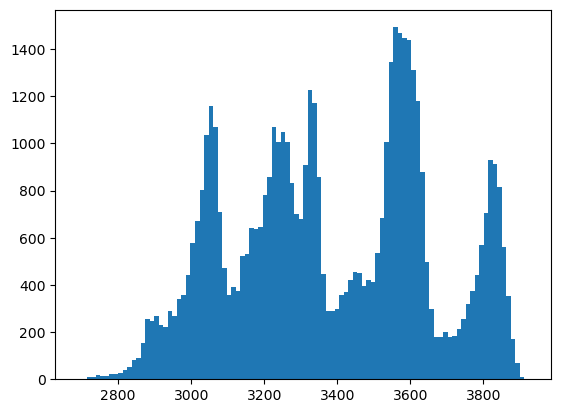

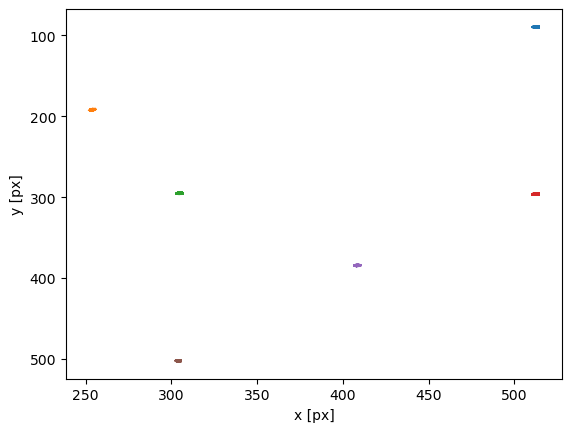

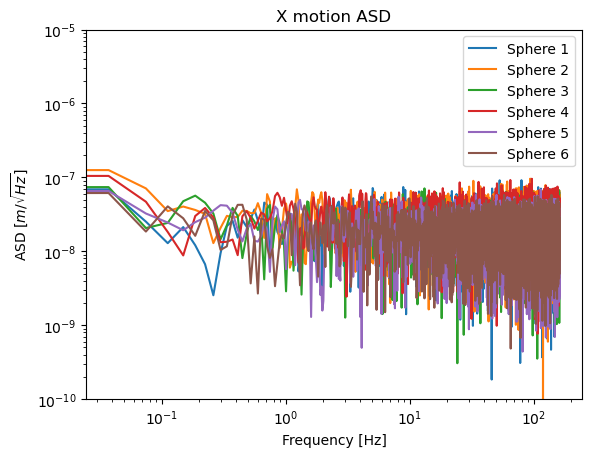

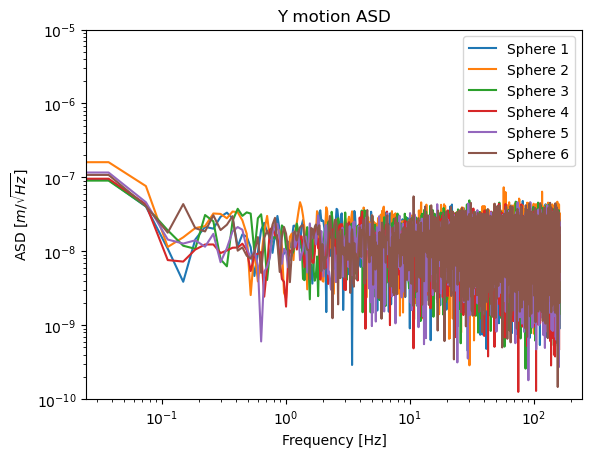

In [6]:
filename = '9-22-23_6beams.avi'
framerate = 323.31
[spheres, f] = processmovie(filename, framerate)

PSDmaker(spheres, f)

Frame 9074: 2 trajectories present.


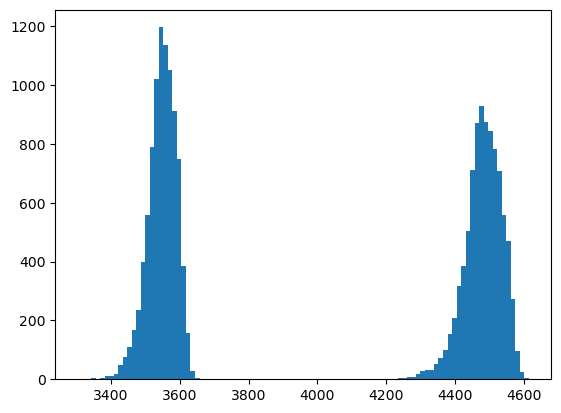

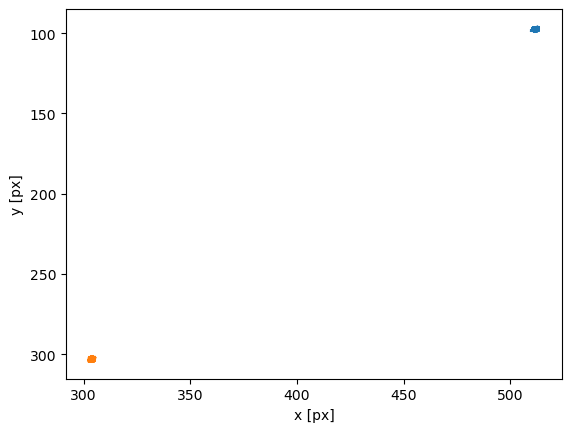

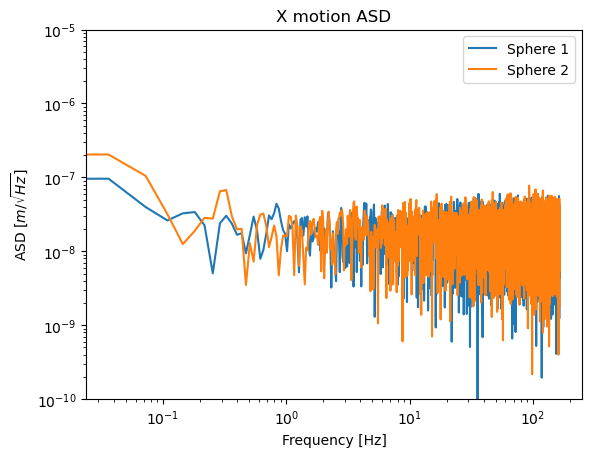

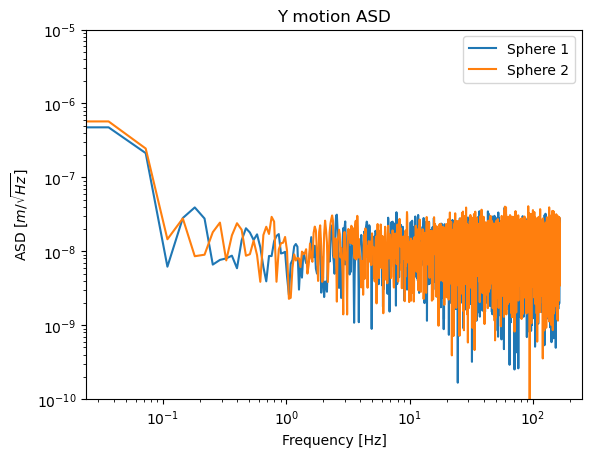

In [3]:
filename = '9-22-23_2beams.avi'
framerate = 328.95
[spheres, f] = processmovie(filename, framerate)

PSDmaker(spheres, f)

Frame 9261: 1 trajectories present.


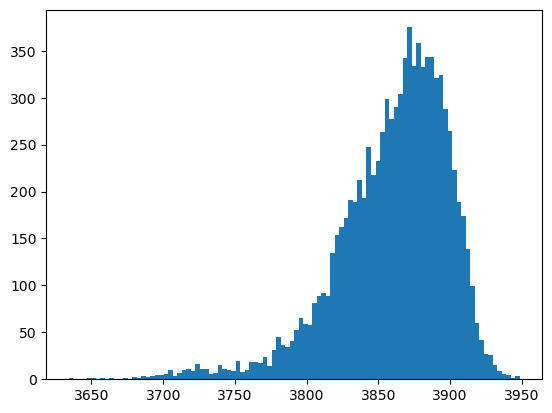

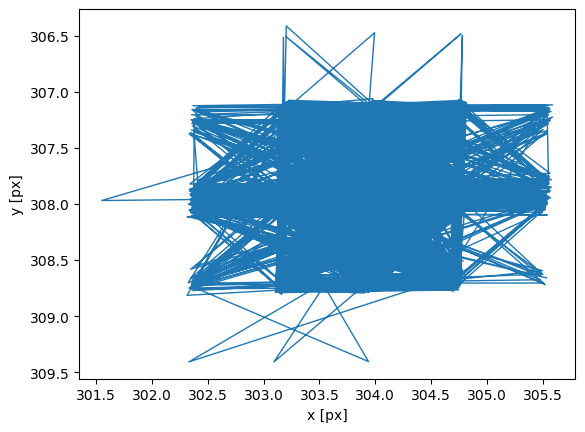

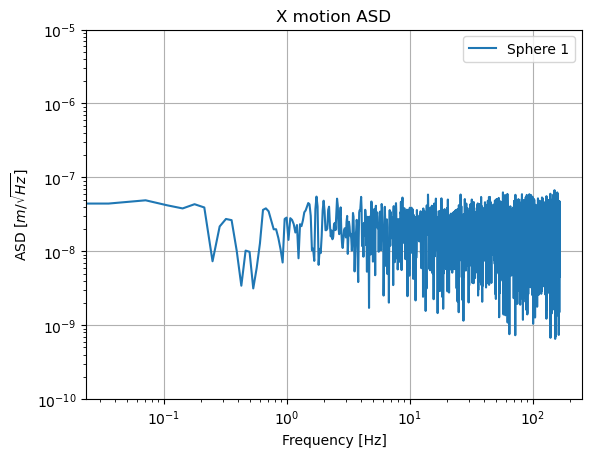

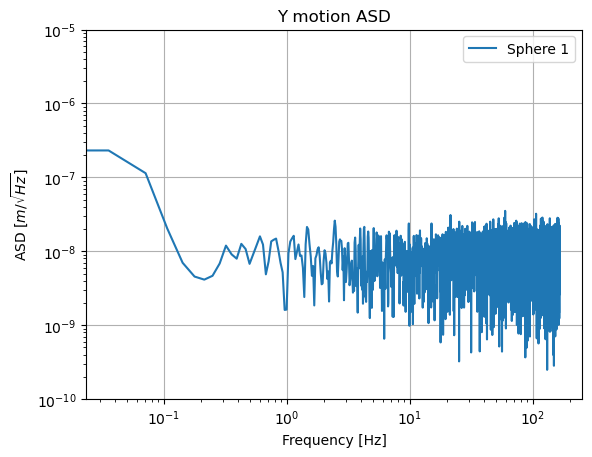

In [3]:
filename = '9-22-23_1beam.avi'
framerate = 328.95
[spheres, f] = processmovie(filename, framerate)

PSDmaker(spheres, f)

In [3]:
## now fit with Lorentzian

def lorentzian(f, f0, gam, cal_fac):
  kb = 1.38e-23 # Boltzmann's constant, SI units
  temp = 293 # Room temp, K
  m = 1e-12 # Mass given in problem set, kg
  omega = 2*np.pi*f
  omega0 = 2*np.pi*f0
  return 1/(cal_fac)**2 * 2*kb*temp/m * gam/((omega0**2 - omega**2)**2 + omega**2*gam**2)

In [9]:
fig=plt.figure()
coords = ["Sphere 1 X", "Sphere 1 Y", "Sphere 2 X", "Sphere 2 Y"]
cal_facs = [] # array to store the calibration factors

NFFT = 2000

for idx, coord in enumerate(coords):

  dat, freqs = psd(xorig[:,idx], Fs=framerate, NFFT=NFFT)
  init_guess = [freqs[np.argmax(dat)],100,1e-7] # guess for the initial parameters
  best_params, cov = curve_fit(lorentzian, freqs, dat, p0=init_guess)

  plt.subplot(1,4,idx+1)
  plt.semilogy(freqs, dat, 'k', label="Data")
  plt.plot(freqs, lorentzian(freqs,*best_params), 'r', lw=1, label="Fit")
  plt.xlabel('Frequency [Hz]')
  if(idx == 0):
    plt.ylabel("PSD [m$^2$/Hz]")
    plt.legend()
  plt.title(coord)

  cal_facs.append(best_params[2]) ## save the calibration factor for later use

fig.set_size_inches(20,5)
cal_facs

NameError: name 'xorig' is not defined

<Figure size 640x480 with 0 Axes>